
# Airsim.Client 
> Connects to the Airsim simulator and enables higher level procedures



In [ ]:
#| default_exp airsim.test_client

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
# skip_showdoc: true to avoid running cells when rendering docs, and skip_exec: true to skip this notebook when running tests. 
# this should be a raw cell 

In [ ]:
#| export

from fastcore.utils import *
import random

import numpy as np
import cv2
import UAV.airsim_python_client as airsim
from UAV.airsim_python_client import MultirotorClient
import UAV.params as params

import logging
from UAV.airsim.client import AirSimClient

In [ ]:
#| export
logging.basicConfig(format='%(asctime)-8s,%(msecs)-3d %(levelname)5s [%(filename)10s:%(lineno)3d] %(message)s',
                    datefmt='%H:%M:%S',
                    level=params.LOGGING_LEVEL)
logger = logging.getLogger(params.LOGGING_NAME)

In [ ]:
#| hide
from fastcore.utils import *
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
%%capture
from UAV.utils.display import *
from UAV.utils.sim_linux import *
from matplotlib import pyplot as plt

DEBUG  | matplotlib      | 58.866 | __init__.py:305 | MainThread         | matplotlib data path: /home/jn/PycharmProjects/UAV/venv/lib/python3.10/site-packages/matplotlib/mpl-data
DEBUG  | matplotlib      | 58.870 | __init__.py:305 | MainThread         | CONFIGDIR=/home/jn/.config/matplotlib
DEBUG  | matplotlib      | 58.871 | __init__.py:1479 | MainThread         | interactive is False
DEBUG  | matplotlib      | 58.872 | __init__.py:1480 | MainThread         | platform is linux
DEBUG  | matplotlib      | 58.899 | __init__.py:305 | MainThread         | CACHEDIR=/home/jn/.cache/matplotlib
DEBUG  | matplotlib.font | 58.902 | font_manager.py:1543 | MainThread         | Using fontManager instance from /home/jn/.cache/matplotlib/fontlist-v330.json


In [ ]:
show_doc(RunSim)

---

### RunSim

>      RunSim (name:str='Coastline', resx:int=800, resy:int=600,
>              windowed:str|None='windowed', settings:str='settings.json')

Run the Airsim simulator

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| name | str | Coastline | name of the simulator environment |
| resx | int | 800 | window size  x |
| resy | int | 600 | window size  y |
| windowed | str \| None | windowed | windowed or fullscreen |
| settings | str | settings.json | settings file |

In [ ]:
rs = RunSim("AirSimNH", settings="config/settings_high_res.json")

Settings file config/settings_high_res.json not found.
Starting Airsim  ['/home/jn/Airsim/AirSimNH/LinuxNoEditor/AirSimNH/Binaries/Linux/AirSimNH', '-ResX=800', '-ResY=600', '-windowed']
Started Airsim AirSimNH


In [ ]:
#|eval: false
show_doc(AirSimClient)

---

[source](https://github.com/johnnewto/UAV/blob/main/UAV/airsim/client.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### AirSimClient

>      AirSimClient (ip='', port:int=41451, timeout_value=3600)

Multirotor Client for the Airsim simulator with higher level procedures

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| ip | str |  | rpc connection address |
| port | int | 41451 | rpc connection port |
| timeout_value | int | 3600 | timeout for client ping in seconds |

In [ ]:
#|eval: false
show_doc(AirSimClient.place_object)

---

[source](https://github.com/johnnewto/UAV/blob/main/UAV/airsim/client.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### AirSimClient.place_object

>      AirSimClient.place_object (name:str, x:float, y:float, z:float,
>                                 scale:float=1.0, physics_enabled:bool=False)

Place an object in the simulator
First check to see if the asset it is based on exists

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| name | str |  | asset name |
| x | float |  | position x |
| y | float |  | position y |
| z | float |  | position z |
| scale | float | 1.0 | scale |
| physics_enabled | bool | False | physics enabled |

In [ ]:
asc = AirSimClient()

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)


In [ ]:
asc.place_object("Sofa_02", 5.0, 0.0, -1.0, scale=0.5 )

The sofa can be seen at the location with `rs.client.simGetObjectPose("Sofa_02")`
The sofa can be moved with `rs.move_asset(x,y,z,asset_name)`

In [ ]:
asc.simGetObjectPose("Sofa_02")

<Pose> {   'orientation': <Quaternionr> {   'w_val': nan,
    'x_val': nan,
    'y_val': nan,
    'z_val': nan},
    'position': <Vector3r> {   'x_val': nan,
    'y_val': nan,
    'z_val': nan}}

In [ ]:
#### Get image from one camera

In [ ]:
#|eval: false
show_doc(AirSimClient.get_image)

---

### AirSimClient.get_image

>      AirSimClient.get_image (camera_name:str='0', rgb2bgr:bool=False)

Get an image from camera `camera_name`

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| camera_name | str | 0 | camera name |
| rgb2bgr | bool | False | convert to bgr |
| **Returns** | **ndarray** |  | **image** |

DEBUG  | matplotlib.pypl | 02.408 |  pyplot.py:339 | MainThread         | Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG  | matplotlib.pypl | 02.409 |  pyplot.py:339 | MainThread         | Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG  | matplotlib.font | 02.412 | font_manager.py:1379 | MainThread         | findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG  | matplotlib.font | 02.413 | font_manager.py:1391 | MainThread         | findfont: score(FontEntry(fname='/home/jn/PycharmProjects/UAV/venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG  | matplotlib.font | 02.414 | font_manager.py:1391 | MainThread         | findfont: score(FontEntry(fname='/home/jn/PycharmProjects/UAV/venv/lib/python3.10/site-packages/matp

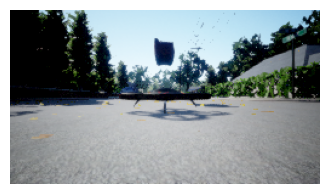

In [ ]:
img = asc.get_image(rgb2bgr=True)
ax = show_image(img)

In [ ]:
#|eval: false
show_doc(AirSimClient.get_images)

---

### AirSimClient.get_images

>      AirSimClient.get_images (camera_names:list=['0'], rgb2bgr:bool=False)

Get images from the simulator of cameras `camera_names`

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| camera_names | list | ['0'] | camera names |
| rgb2bgr | bool | False | convert to rgb |
| **Returns** | **list** |  | **images** |

> Note this seems to be slow

DEBUG  | matplotlib.font | 03.102 | font_manager.py:1379 | MainThread         | findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG  | matplotlib.font | 03.102 | font_manager.py:1391 | MainThread         | findfont: score(FontEntry(fname='/home/jn/PycharmProjects/UAV/venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG  | matplotlib.font | 03.103 | font_manager.py:1391 | MainThread         | findfont: score(FontEntry(fname='/home/jn/PycharmProjects/UAV/venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG  | matplotlib.font | 03.103 | font_manager.py:1391 | MainThread         | findfont: score(FontEntry(fname='/home/jn/PycharmProjects/UAV/venv/lib/p

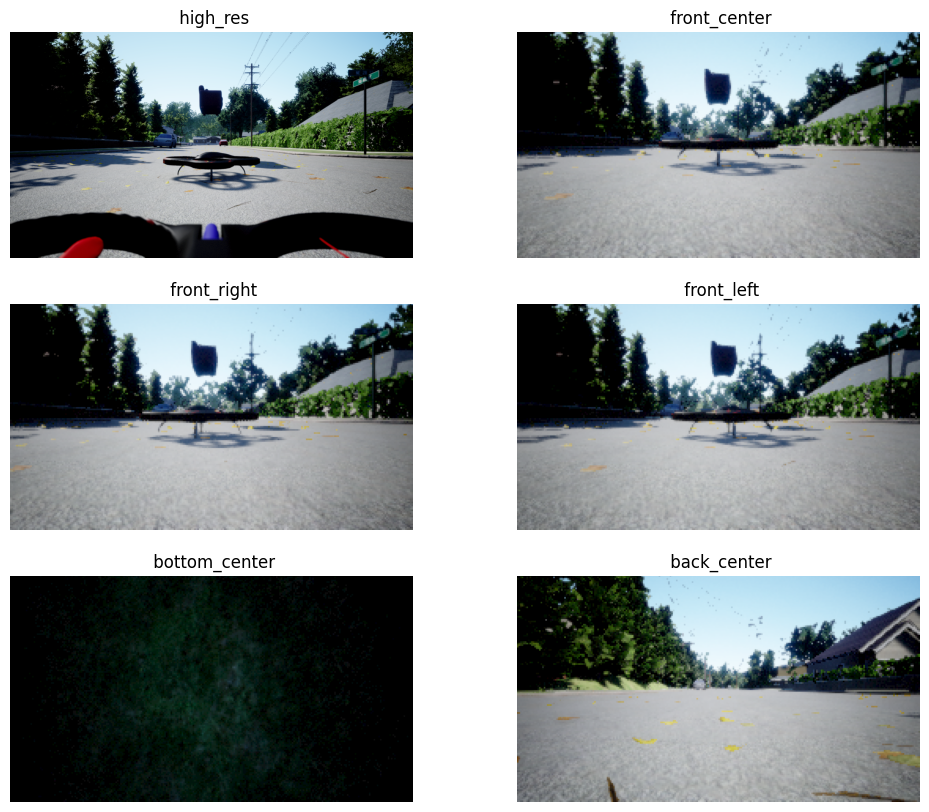

In [ ]:
#|output: false
cams = ["high_res", "front_center", "front_right", "front_left", "bottom_center", "back_center"]
imgs = asc.get_images(cams, rgb2bgr=True)

_,axs = plt.subplots(3,2,figsize=(12,10))
for i,ax in enumerate(axs.flatten()): show_image(imgs[i], ax=ax, title=f' {cams[i]}')

In [ ]:
#| export
@patch
def get_state(self:AirSimClient) -> MultirotorClient:
    """Get the state of the drone"""
    return self.simGetGroundTruthKinematics()


In [ ]:
#|eval: false
show_doc(AirSimClient.get_state)

---

### AirSimClient.get_state

>      AirSimClient.get_state ()

Get the state of the drone

In [ ]:
#| export
@patch
def takeoff(self:AirSimClient,  # airsim client
            timeout: float = 5.0,  # timeout
            ) -> bool:  # success
    """Takeoff the drone"""
    return super().takeoffAsync(timeout_sec=timeout).join()

In [ ]:
#|eval: false
show_doc(AirSimClient.takeoff)

---

### AirSimClient.takeoff

>      AirSimClient.takeoff (timeout:float=5.0)

Takeoff the drone

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| timeout | float | 5.0 | timeout |
| **Returns** | **bool** |  | **success** |

In [ ]:
rs.exit()

Airsim exited with rc = 143


In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()